In [1]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from sklearn.metrics import confusion_matrix

# Neural Network from Scratch for Fashion MNIST

This notebook implements a **fully-connected neural network** from scratch using only NumPy, trained on the Fashion MNIST dataset.

## What We're Building
A 4-layer neural network: **784 → 256 → 128 → 64 → 10**

In [2]:
class DenseLayer:
    def __init__(self, n_input, n_neurons, init="he"):

        if init == "he":
            self.W = np.random.randn(n_input, n_neurons) * np.sqrt(2.0 / n_input)
        elif init == "xavier":
            self.W = np.random.randn(n_input, n_neurons) * np.sqrt(1.0 / n_input)
        else:
            self.W = np.random.randn(n_input, n_neurons) * 0.01

        self.b = np.zeros((1, n_neurons))

    def forward(self, A_prev):
        self.A_prev = A_prev
        self.Z = np.dot(A_prev, self.W) + self.b
        return self.Z

    def backward(self, dZ):
        m = self.A_prev.shape[0]

        self.dW = (1/m) * np.dot(self.A_prev.T, dZ)
        self.db = (1/m) * np.sum(dZ, axis=0, keepdims=True)
        dA_prev = np.dot(dZ, self.W.T)

        return dA_prev

    def update(self, lr):
        self.W -= lr * self.dW
        self.b -= lr * self.db

## Dense (Fully Connected) Layer

### Forward Pass
Each neuron computes a weighted sum of inputs plus a bias:

$$Z = X \cdot W + b$$

Where:
- $X$ is the input matrix of shape $(m, n_{in})$
- $W$ is the weight matrix of shape $(n_{in}, n_{out})$
- $b$ is the bias vector of shape $(1, n_{out})$
- $m$ is the batch size

### Backward Pass (Gradient Computation)
Using the chain rule, we compute gradients:

$$\frac{\partial L}{\partial W} = \frac{1}{m} X^T \cdot dZ$$

$$\frac{\partial L}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} dZ_i$$

$$\frac{\partial L}{\partial X} = dZ \cdot W^T$$

### Weight Initialization
- **He Initialization**: $W \sim \mathcal{N}(0, \sqrt{\frac{2}{n_{in}}})$ — best for ReLU
- **Xavier Initialization**: $W \sim \mathcal{N}(0, \sqrt{\frac{1}{n_{in}}})$ — best for tanh/sigmoid

In [3]:
class Activation:
    def __init__(self, type):
        self.type = type

    def forward(self, Z):
        self.Z = Z

        if self.type == "relu":
            self.A = np.maximum(0, Z)

        elif self.type == "softmax":
            expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
            self.A = expZ / np.sum(expZ, axis=1, keepdims=True)

        elif self.type == "linear":
            self.A = Z

        return self.A

    def backward(self, dA=None, Y=None):

        if self.type == "relu":
            dZ = dA * (self.Z > 0)

        elif self.type == "softmax":
            dZ = self.A - Y

        elif self.type == "linear":
            dZ = dA

        return dZ

## Activation Functions

### ReLU (Rectified Linear Unit)
Used in hidden layers to introduce non-linearity:

$$\text{ReLU}(z) = \max(0, z)$$

**Derivative:**
$$\frac{\partial \text{ReLU}}{\partial z} = \begin{cases} 1 & \text{if } z > 0 \\ 0 & \text{otherwise} \end{cases}$$

### Softmax
Used in the output layer for multi-class classification:

$$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

This converts raw scores (logits) into probabilities that sum to 1.

**Note:** For numerical stability, we compute: $e^{z_i - \max(z)}$

In [4]:
def one_hot(Y, num_classes=10):
    m = Y.shape[0]
    Y_one = np.zeros((m, num_classes))
    Y_one[np.arange(m), Y] = 1
    return Y_one


def compute_loss(Y, A):
    m = Y.shape[0]
    return -np.sum(Y * np.log(A + 1e-8)) / m


def accuracy(Y, A):
    return np.mean(np.argmax(A, axis=1) == Y)


def create_mini_batches(X, Y, batch_size):
    m = X.shape[0]
    indices = np.random.permutation(m)

    X_shuffled = X[indices]
    Y_shuffled = Y[indices]

    batches = []

    for i in range(0, m, batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        Y_batch = Y_shuffled[i:i+batch_size]
        batches.append((X_batch, Y_batch))

    return batches

## Loss Function & Utilities

### Cross-Entropy Loss
For multi-class classification with softmax output:

$$L = -\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K} y_{ik} \log(\hat{y}_{ik})$$

Where:
- $y_{ik}$ is the one-hot encoded true label
- $\hat{y}_{ik}$ is the predicted probability for class $k$

### One-Hot Encoding
Converts class labels into vectors:
$$\text{label } 3 \rightarrow [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]$$

### Gradient of Softmax + Cross-Entropy
The combined gradient simplifies beautifully to:
$$\frac{\partial L}{\partial z} = \hat{y} - y$$

In [5]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train.reshape(-1, 784) / 255.0
X_test = X_test.reshape(-1, 784) / 255.0

# Train / Dev Split
dev_size = 5000
X_dev = X_train[:dev_size]
y_dev = y_train[:dev_size]

X_train = X_train[dev_size:]
y_train = y_train[dev_size:]

Y_train = one_hot(y_train)
Y_dev = one_hot(y_dev)
Y_test = one_hot(y_test)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
import matplotlib.pyplot as plt

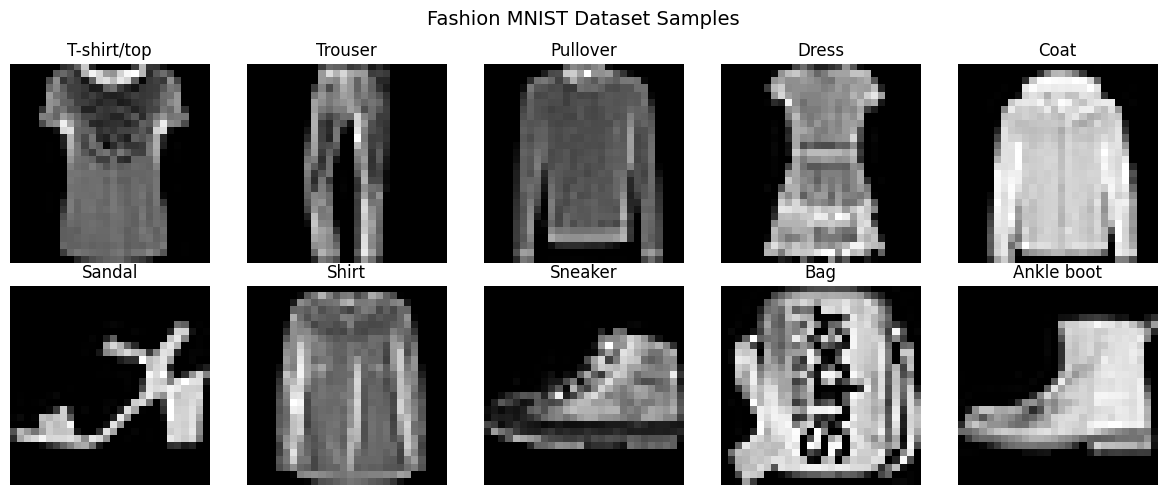

In [7]:
# Visualize sample images from the Fashion MNIST dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Fashion MNIST Dataset Samples', fontsize=14)

for i, ax in enumerate(axes.flatten()):
    # Find an image for each class
    idx = np.where(y_train == i)[0][0]
    ax.imshow(X_train[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f'{class_names[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Network Architecture

```
Input (784) → Dense(256) → ReLU → Dense(128) → ReLU → Dense(64) → ReLU → Dense(10) → Softmax → Output
```

| Layer | Input Size | Output Size | Parameters |
|-------|------------|-------------|------------|
| Dense 1 | 784 | 256 | 784×256 + 256 = 200,960 |
| Dense 2 | 256 | 128 | 256×128 + 128 = 32,896 |
| Dense 3 | 128 | 64 | 128×64 + 64 = 8,256 |
| Dense 4 | 64 | 10 | 64×10 + 10 = 650 |
| **Total** | | | **242,762** |

In [8]:
dense1 = DenseLayer(784, 256, init="he")
act1 = Activation("relu")

dense2 = DenseLayer(256, 128, init="he")
act2 = Activation("relu")

dense3 = DenseLayer(128, 64, init="he")
act3 = Activation("relu")

dense4 = DenseLayer(64, 10, init="xavier")
act4 = Activation("softmax")

## Training: Forward & Backward Pass

### Forward Pass
Sequentially compute through each layer:
$$Z^{[l]} = A^{[l-1]} \cdot W^{[l]} + b^{[l]}$$
$$A^{[l]} = g(Z^{[l]})$$

### Backpropagation (Chain Rule)
Gradients flow backward through the network:

1. **Output Layer:** $dZ^{[4]} = A^{[4]} - Y$ (softmax + cross-entropy)
2. **Hidden Layers:** $dZ^{[l]} = dA^{[l]} \odot g'(Z^{[l]})$
3. **Weight Update:** $W^{[l]} = W^{[l]} - \alpha \cdot \frac{\partial L}{\partial W^{[l]}}$

Where $\alpha$ is the learning rate and $\odot$ denotes element-wise multiplication.

In [9]:
epochs = 20
lr = 0.02
batch_size = 32

for epoch in range(epochs):

    mini_batches = create_mini_batches(X_train, Y_train, batch_size)

    epoch_loss = 0

    for X_batch, Y_batch in mini_batches:

        # Forward
        Z1 = dense1.forward(X_batch)
        A1 = act1.forward(Z1)

        Z2 = dense2.forward(A1)
        A2 = act2.forward(Z2)

        Z3 = dense3.forward(A2)
        A3 = act3.forward(Z3)

        Z4 = dense4.forward(A3)
        A4 = act4.forward(Z4)

        # Loss
        loss = compute_loss(Y_batch, A4)
        epoch_loss += loss

        # Backward


        dZ4 = act4.backward(Y=Y_batch)
        dA3 = dense4.backward(dZ4)

        dZ3 = act3.backward(dA3)
        dA2 = dense3.backward(dZ3)

        dZ2 = act2.backward(dA2)
        dA1 = dense2.backward(dZ2)

        dZ1 = act1.backward(dA1)
        dense1.backward(dZ1)

        # Update
        dense1.update(lr)
        dense2.update(lr)
        dense3.update(lr)
        dense4.update(lr)


    Z1 = dense1.forward(X_dev)
    A1 = act1.forward(Z1)
    Z2 = dense2.forward(A1)
    A2 = act2.forward(Z2)
    Z3 = dense3.forward(A2)
    A3 = act3.forward(Z3)
    Z4 = dense4.forward(A3)
    A_dev = act4.forward(Z4)

    dev_loss = compute_loss(Y_dev, A_dev)
    dev_acc = accuracy(y_dev, A_dev)

    print(f"Epoch {epoch+1} | Train Loss: {epoch_loss/len(mini_batches):.4f} | Dev Loss: {dev_loss:.4f} | Dev Acc: {dev_acc:.4f}")


Epoch 1 | Train Loss: 0.6331 | Dev Loss: 0.4800 | Dev Acc: 0.8284
Epoch 2 | Train Loss: 0.4431 | Dev Loss: 0.4312 | Dev Acc: 0.8436
Epoch 3 | Train Loss: 0.3960 | Dev Loss: 0.3814 | Dev Acc: 0.8644
Epoch 4 | Train Loss: 0.3667 | Dev Loss: 0.3630 | Dev Acc: 0.8672
Epoch 5 | Train Loss: 0.3440 | Dev Loss: 0.3481 | Dev Acc: 0.8730
Epoch 6 | Train Loss: 0.3265 | Dev Loss: 0.3368 | Dev Acc: 0.8754
Epoch 7 | Train Loss: 0.3123 | Dev Loss: 0.3257 | Dev Acc: 0.8808
Epoch 8 | Train Loss: 0.2997 | Dev Loss: 0.3191 | Dev Acc: 0.8864
Epoch 9 | Train Loss: 0.2880 | Dev Loss: 0.3165 | Dev Acc: 0.8876
Epoch 10 | Train Loss: 0.2787 | Dev Loss: 0.3051 | Dev Acc: 0.8908
Epoch 11 | Train Loss: 0.2690 | Dev Loss: 0.2991 | Dev Acc: 0.8910
Epoch 12 | Train Loss: 0.2605 | Dev Loss: 0.2966 | Dev Acc: 0.8936
Epoch 13 | Train Loss: 0.2524 | Dev Loss: 0.3029 | Dev Acc: 0.8906
Epoch 14 | Train Loss: 0.2449 | Dev Loss: 0.3131 | Dev Acc: 0.8880
Epoch 15 | Train Loss: 0.2382 | Dev Loss: 0.3014 | Dev Acc: 0.8908
Epoc

In [10]:
Z1 = dense1.forward(X_test)
A1 = act1.forward(Z1)
Z2 = dense2.forward(A1)
A2 = act2.forward(Z2)
Z3 = dense3.forward(A2)
A3 = act3.forward(Z3)
Z4 = dense4.forward(A3)

A_test = act4.forward(Z4)

predictions = np.argmax(A_test, axis=1)

cm = confusion_matrix(y_test, predictions)

print("\nConfusion Matrix:")
print(cm)

print("\nTest Accuracy:", accuracy(y_test, A_test))


Confusion Matrix:
[[856   1  32  21   4   1  80   0   5   0]
 [  3 973   3  16   3   0   2   0   0   0]
 [ 15   1 921  11  33   1  17   1   0   0]
 [ 23   7  25 897  26   0  17   0   4   1]
 [  0   1 268  25 684   0  21   0   1   0]
 [  0   0   0   0   0 952   0  29   0  19]
 [131   1 215  27  61   0 559   0   6   0]
 [  0   0   0   0   0  12   0 967   0  21]
 [ 13   0  13   6   3   3   7   8 947   0]
 [  1   0   0   0   0   5   0  38   0 956]]

Test Accuracy: 0.8712


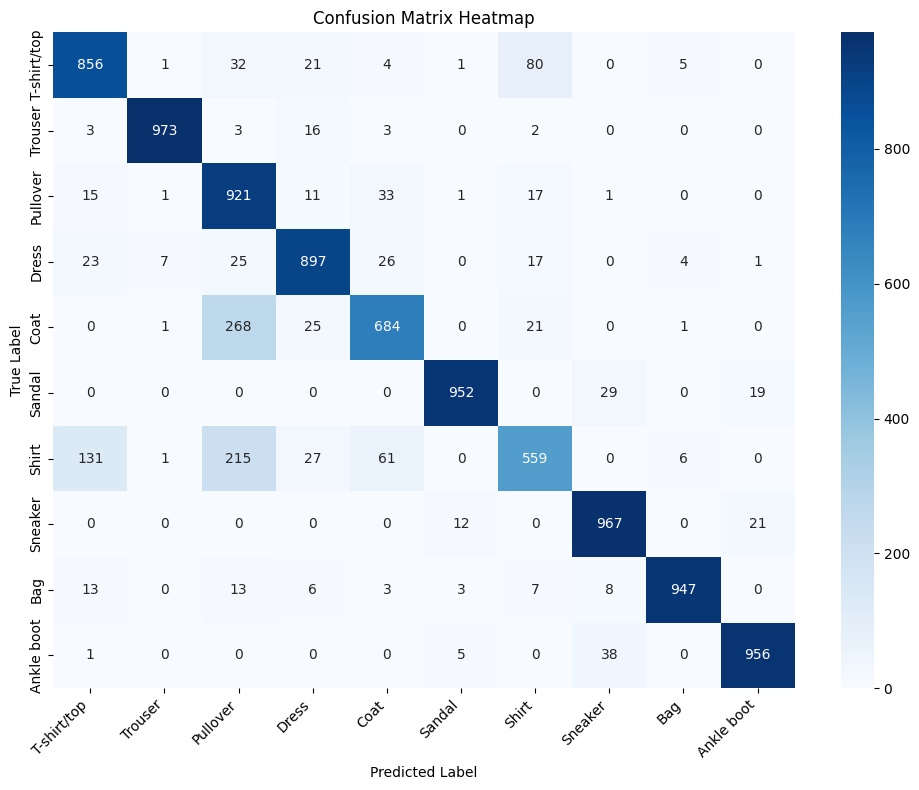

In [11]:
# Confusion Matrix Heatmap
import seaborn as sns

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

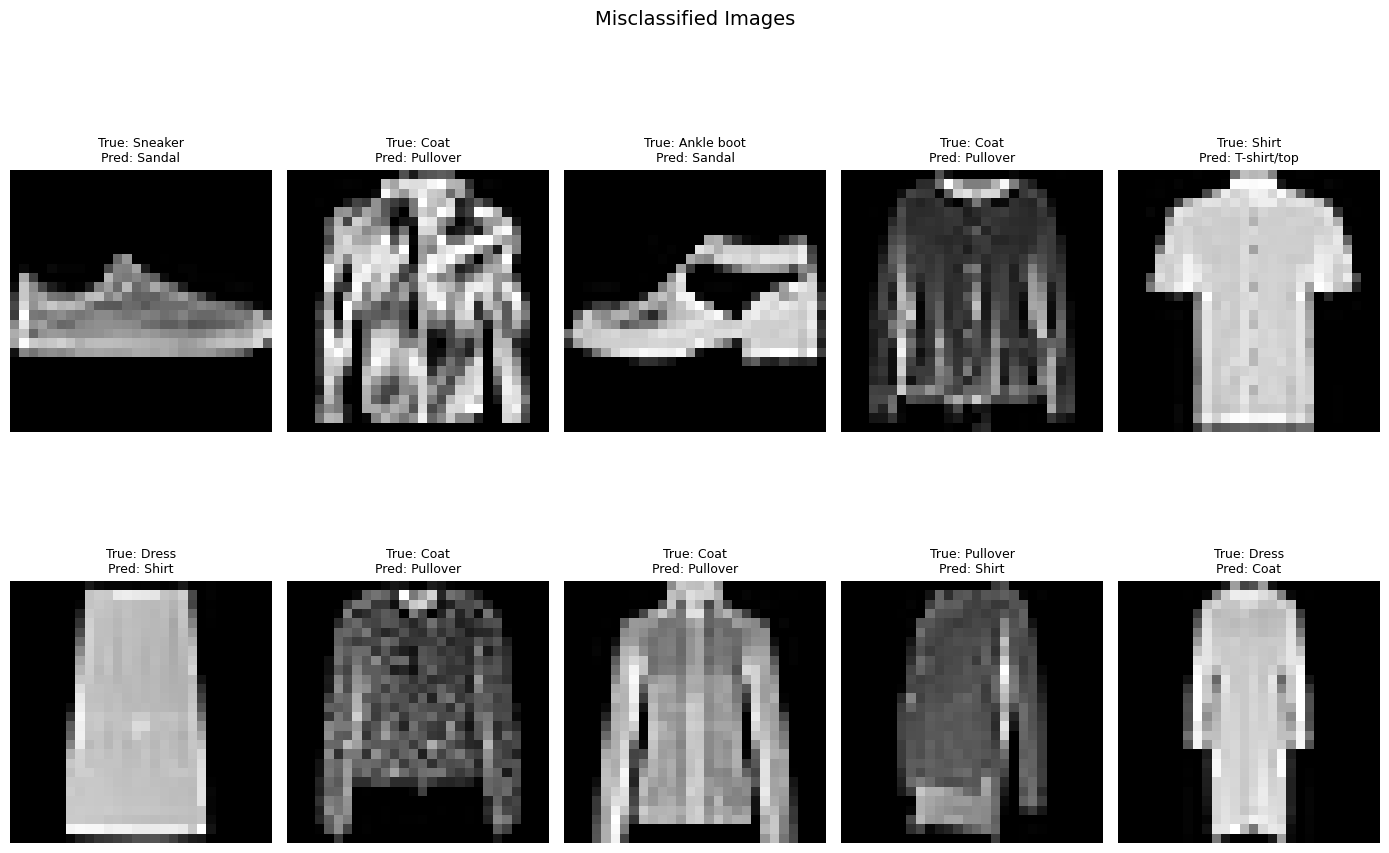

Total misclassified: 1288 out of 10000 (12.88%)


In [13]:
# Visualize misclassified images
misclassified_idx = np.where(predictions != y_test)[0]

fig, axes = plt.subplots(2, 5, figsize=(14, 10))
fig.suptitle('Misclassified Images', fontsize=14)

for i, ax in enumerate(axes.flatten()):
    idx = misclassified_idx[i]
    ax.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f'True: {class_names[y_test[idx]]}\nPred: {class_names[predictions[idx]]}', fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Total misclassified: {len(misclassified_idx)} out of {len(y_test)} ({100*len(misclassified_idx)/len(y_test):.2f}%)")

In [ ]:
import matplotlib.pyplot as plt

batch_sizes = [16, 32, 64, 128]
epochs = 20
lr = 0.02

history = {}

In [ ]:
def train_with_batch_size(batch_size):

    # Reinitialize model every run
    dense1 = DenseLayer(784, 256, init="he")
    act1 = Activation("relu")

    dense2 = DenseLayer(256, 128, init="he")
    act2 = Activation("relu")

    dense3 = DenseLayer(128, 64, init="he")
    act3 = Activation("relu")

    dense4 = DenseLayer(64, 10, init="xavier")
    act4 = Activation("softmax")

    train_losses = []

    for epoch in range(epochs):

        mini_batches = create_mini_batches(X_train, Y_train, batch_size)
        epoch_loss = 0

        for X_batch, Y_batch in mini_batches:

            # Forward
            Z1 = dense1.forward(X_batch)
            A1 = act1.forward(Z1)

            Z2 = dense2.forward(A1)
            A2 = act2.forward(Z2)

            Z3 = dense3.forward(A2)
            A3 = act3.forward(Z3)

            Z4 = dense4.forward(A3)
            A4 = act4.forward(Z4)

            loss = compute_loss(Y_batch, A4)
            epoch_loss += loss

            # Backward
            dZ4 = act4.backward(Y=Y_batch)
            dA3 = dense4.backward(dZ4)

            dZ3 = act3.backward(dA3)
            dA2 = dense3.backward(dZ3)

            dZ2 = act2.backward(dA2)
            dA1 = dense2.backward(dZ2)

            dZ1 = act1.backward(dA1)
            dense1.backward(dZ1)

            # Update
            dense1.update(lr)
            dense2.update(lr)
            dense3.update(lr)
            dense4.update(lr)

        train_losses.append(epoch_loss / len(mini_batches))

    return train_losses


In [ ]:
for bs in batch_sizes:
    print("Training with batch size:", bs)
    history[bs] = train_with_batch_size(bs)


Training with batch size: 16
Training with batch size: 32
Training with batch size: 64
Training with batch size: 128


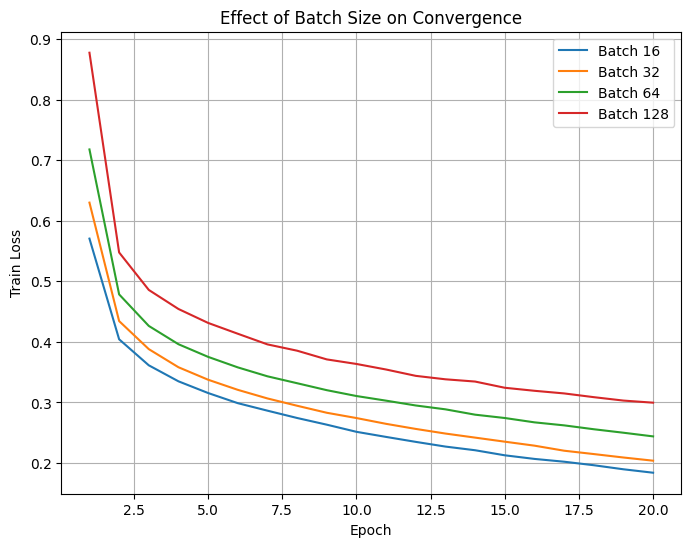

In [ ]:
plt.figure(figsize=(8,6))

for bs in batch_sizes:
    plt.plot(range(1, epochs+1), history[bs], label=f"Batch {bs}")

plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Effect of Batch Size on Convergence")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
batch_size = 32
epochs = 20
learning_rates = [0.001, 0.005, 0.01, 0.02, 0.05]
history_lr = {}

def train_with_lr(lr):

    # Reinitialize model each run
    dense1 = DenseLayer(784, 256, init="he")
    act1 = Activation("relu")

    dense2 = DenseLayer(256, 128, init="he")
    act2 = Activation("relu")

    dense3 = DenseLayer(128, 64, init="he")
    act3 = Activation("relu")

    dense4 = DenseLayer(64, 10, init="xavier")
    act4 = Activation("softmax")

    train_losses = []

    for epoch in range(epochs):

        mini_batches = create_mini_batches(X_train, Y_train, batch_size)
        epoch_loss = 0

        for X_batch, Y_batch in mini_batches:

            # Forward
            Z1 = dense1.forward(X_batch)
            A1 = act1.forward(Z1)

            Z2 = dense2.forward(A1)
            A2 = act2.forward(Z2)

            Z3 = dense3.forward(A2)
            A3 = act3.forward(Z3)

            Z4 = dense4.forward(A3)
            A4 = act4.forward(Z4)

            loss = compute_loss(Y_batch, A4)
            epoch_loss += loss

            # Backward
            dZ4 = act4.backward(Y=Y_batch)
            dA3 = dense4.backward(dZ4)

            dZ3 = act3.backward(dA3)
            dA2 = dense3.backward(dZ3)

            dZ2 = act2.backward(dA2)
            dA1 = dense2.backward(dZ2)

            dZ1 = act1.backward(dA1)
            dense1.backward(dZ1)

            # Update using current learning rate
            dense1.update(lr)
            dense2.update(lr)
            dense3.update(lr)
            dense4.update(lr)

        train_losses.append(epoch_loss / len(mini_batches))

    return train_losses


for lr in learning_rates:
    print("Training with learning rate:", lr)
    history_lr[lr] = train_with_lr(lr)




Training with learning rate: 0.001
Training with learning rate: 0.005
Training with learning rate: 0.01
Training with learning rate: 0.02
Training with learning rate: 0.05


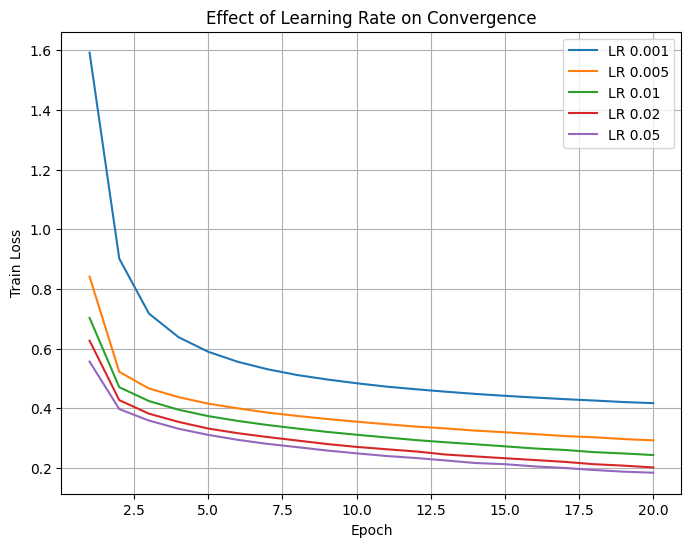

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for lr in learning_rates:
    plt.plot(range(1, epochs+1), history_lr[lr], label=f"LR {lr}")

plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Effect of Learning Rate on Convergence")
plt.legend()
plt.grid(True)
plt.show()
